In [22]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


# Protein Structure Analysis and Prediction Workflow

This notebook demonstrates a workflow for protein structure analysis and prediction using deep learning models.

## Overview

The workflow includes the following steps:

- **Loading and encoding protein structures** into graph representations.
- **Using a trained encoder and decoder** to generate sequence and contact predictions.
- **Visualizing protein structures and contact maps** for qualitative assessment.
- **Evaluating model performance** with metrics such as ROC, precision-recall, RMSD, and lDDT.
- **Utilities for handling PDB files**, extracting features, and plotting results.

## Technologies Used

The workflow leverages **PyTorch**, **PyTorch Geometric**, and custom modules for advanced protein modeling tasks.

In [23]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import toytree
import tqdm
from matplotlib import pyplot as plt
import torch
from src import pdbgraph
converter = pdbgraph.PDB2PyG( aapropcsv = 'config/aaindex1.csv',)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [24]:
modelname = 'testfft400'
modeldir = './models/'

with open( modeldir + modelname + '.pkl', 'rb') as f:
	encoder, decoder = pickle.load(f)

print('Loaded model:', modelname)
print('Encoder:', encoder)
print('Decoder:', decoder)
encoder.eval()
decoder.eval()
encoder.to(device)
decoder.to(device)

Loaded model: testfft400
Encoder: mk1_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_contactPoints_res): TransformerConv(400, 400, heads=5)
      (res_hbond_res): TransformerConv(400, 400, heads=5)
    )
  )
  (norms): ModuleList(
    (0): GraphNorm(400)
  )
  (bn): BatchNorm1d(857, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.005, inplace=False)
  (jk): JumpingKnowledge(cat)
  (ffin): Sequential(
    (0): Linear(in_features=1017, out_features=800, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=800, out_features=400, bias=True)
    (3): GELU(approximate='none')
    (4): DynamicTanh(normalized_shape=400, alpha_init_value=0.5, channels_last=True)
  )
  (lin): Sequential(
    (0): DynamicTanh(normalized_shape=400, alpha_init_value=0.5, channels_last=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bia

MultiMonoDecoder(
  (decoders): ModuleDict(
    (sequence_transformer): Transformer_AA_Decoder(
      (input_proj): Sequential(
        (0): Linear(in_features=276, out_features=400, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.005, inplace=False)
        (3): Linear(in_features=400, out_features=400, bias=True)
        (4): DynamicTanh(normalized_shape=400, alpha_init_value=0.5, channels_last=True)
      )
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-2): 3 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=400, out_features=400, bias=True)
            )
            (linear1): Linear(in_features=400, out_features=2048, bias=True)
            (dropout): Dropout(p=0.005, inplace=False)
            (linear2): Linear(in_features=2048, out_features=400, bias=True)
            (norm1): LayerNorm((400,), eps=1e-05, elementwise_a

In [25]:
from torch_geometric.data import DataLoader , HeteroData

struct_dat = pdbgraph.StructureDataset('structs_traininffttest.h5')
encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=True)
#encode the structures
encode_alns = True
if encode_alns == True:
	def databatch2list(loader , limit = 10):
		for i,data in enumerate(loader):
			if i > limit:
				break
			data = data.to_data_list()
			for d in data:
				d = d.to(device)
				yield d
	encoder_loader = databatch2list(encoder_loader)
	encoder.encode_structures_fasta(encoder_loader , modeldir + modelname+'_aln_encoded_test.fasta' )

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
0it [00:00, ?it/s]

11it [00:00, 21.97it/s]


In [12]:
encoded_fasta =  modeldir + modelname+'_aln_encoded_test.fasta' 
seqstr = ''
ID = ''
seqdict = {}
with open(encoded_fasta, 'r') as f:
	#read all chars of file into a string
	for line in tqdm.tqdm(f):
		if line[0] == '>' and line[-1] == '\n':
			seqdict[ID] = seqstr
			ID = line[1:].strip()
			seqstr = ''
		else:
			seqstr += line.strip()
del seqdict['']
encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#change index to protid
encoded_df.index = encoded_df.protid
encoded_df = encoded_df.drop( 'protid', axis=1 )

encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
#hex starts at 1
encoded_df['hex2'] = encoded_df.ord.map( lambda x: [ hex(c) for c in x] )

182it [00:00, 150921.97it/s]


In [13]:
charset = 249
#make fasta is shifted by 1 and goes from 1-248 included
#0x01 – 0xFF excluding > (0x3E), = (0x3D), < (0x3C), - (0x2D), Space (0x20), Carriage Return (0x0d) and Line Feed (0x0a)
#replace 0x22 or " which is necesary for nexus files and 0x23 or # which is also necesary

replace_dict = {chr(0):chr(246) , '"':chr(248) , '#':chr(247), '>' : chr(249), '=' : chr(250), '<' : chr(251), '-' : chr(252), ' ' : chr(253) , '\r' : chr(254), '\n' : chr(255) }
rev_replace_dict = { v:k for k,v in replace_dict.items() }

replace_dict_ord = { ord(k):ord(v) for k,v in replace_dict.items() }
rev_replace_dict_ord = { ord(v):ord(k) for k,v in replace_dict.items() }

print(replace_dict)
print(rev_replace_dict)

print( replace_dict_ord )

print(rev_replace_dict_ord)

{'\x00': 'ö', '"': 'ø', '#': '÷', '>': 'ù', '=': 'ú', '<': 'û', '-': 'ü', ' ': 'ý', '\r': 'þ', '\n': 'ÿ'}
{'ö': '\x00', 'ø': '"', '÷': '#', 'ù': '>', 'ú': '=', 'û': '<', 'ü': '-', 'ý': ' ', 'þ': '\r', 'ÿ': '\n'}
{0: 246, 34: 248, 35: 247, 62: 249, 61: 250, 60: 251, 45: 252, 32: 253, 13: 254, 10: 255}
{246: 0, 248: 34, 247: 35, 249: 62, 250: 61, 251: 60, 252: 45, 253: 32, 254: 13, 255: 10}


In [14]:
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))
print(encoded_df)

                                                          seq  \
protid                                                          
A0A2C9M1K8  &÷ø'÷÷'&&÷&\t÷'...   
A0A162JUP8  ø&&&&&''÷'÷÷\t...   
A0A1W9TUR9  ''ø'%ø'\t'%ø'ø...   
A0A350J482  &%!!ø((øøø...   
A0CST5      '÷''øø'''÷'...   
A0A3N5EDV9  ý&'(((('%%((((&ø&ý%%%ý...   
A0A7X4JF48  %%'$!'%$\tø&&...   
A0A838PRK3  ÷\t'$\t÷&÷%%...   
A0A0A6Q3E4  !'÷&&'\t!!&...   
W4U6Q6      %'ø\t(÷!%(%(&%(%%...   

                                                          ord  \
protid                                                          
A0A2C9M1K8  [22, 22, 6, 3, 20, 15, 15, 38, 30, 29, 4, 35, ...   
A0A162JUP8  [19, 19, 17, 34, 12, 37, 8, 1,

In [15]:
import py3Dmol

def view_custom_pdb(pdb_file, chain='A'):
	"""
	Visualize a PDB structure from a file, highlight a specific residue with thicker sticks,
	show the backbone for the selected residue, and add an arrow-like indicator.
	
	Parameters:
	- pdb_file: str, path to the local PDB file.
	- residue_num: int, residue number to highlight.
	- chain: str, the chain identifier (default 'A').
	"""
	# Read the PDB file content
	with open(pdb_file, 'r') as f:
		pdb_content = f.read()

	# Initialize py3Dmol viewer
	viewer = py3Dmol.view(width=800, height=600)
	
	# Add the PDB structure to the viewer
	viewer.addModel(pdb_content, 'pdb')
	
	# Apply cartoon style for the overall structure
	viewer.setStyle({'cartoon': {'color': 'cyan'}})
	
	
	# Add molecular surface for the rest of the structure
	viewer.addSurface(py3Dmol.VDW, {'opacity': 0.5})
	
	
	# Set zoom and background color
	viewer.zoomTo()
	viewer.setBackgroundColor('white')
	
	# Show the structure
	return viewer.show()



A0A2C9M1K8


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

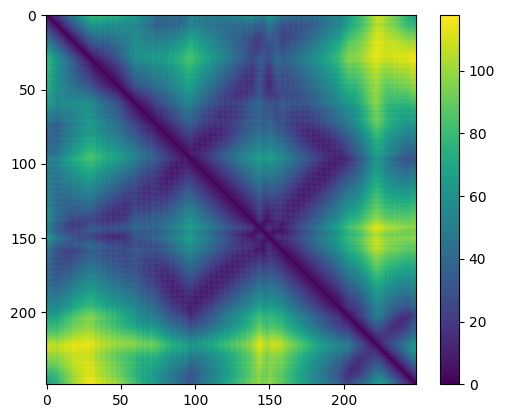

203
torch.Size([203, 20])
HeteroData(
  res={
    x=[203, 20],
    batch=[203],
  },
  positions={ x=[203, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 202] },
  (res, backbone_rev, res)={ edge_index=[2, 202] },
  (godnode4decoder, informs, res)={ edge_index=[2, 203] },
  (res, informs, godnode4decoder)={ edge_index=[2, 203] },
  (res, informs, godnode)={ edge_index=[2, 203] }
)
torch.Size([41209])
tensor([[-26.5140, -20.4237, -14.9705,  ..., -19.9459, -24.7039, -17.0497],
        [-25.9529, -19.9549, -14.8508,  ..., -19.3484, -24.3387, -16.3763],
        [-15.6026, -10.8432, -14.0971,  ..., -18.4161, -19.4473, -17.1272],
        ...,
        [-29.2159, -23.0315, -23.3808,  ..., -22.4661, -12.4967, -23.1766],
        [-21.3670, -21.0040, -23.3560,  ..., -23.9616, -33.6134, -22.4257],
        [-22.8798, -22.8446, -26.2269,  ..., -29.9132, -17.9972, -24.3645]],
       device='cuda:0', grad_fn=<CatBackward0>)
tensor([[9.9952e-01, 

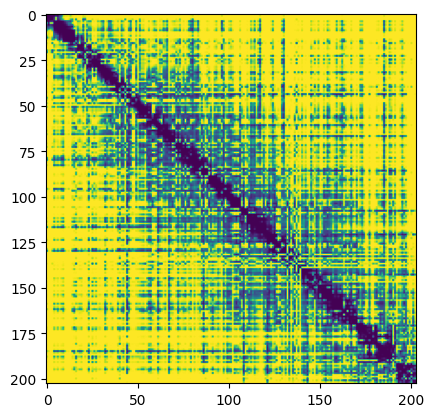

torch.Size([203, 203])
(249, 249)


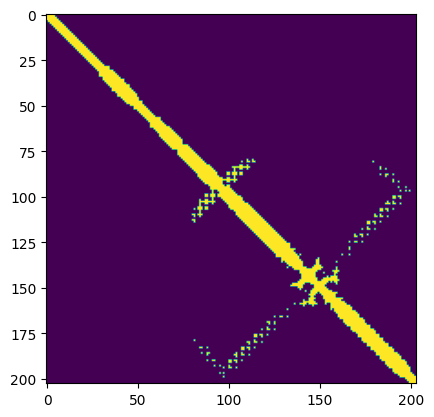

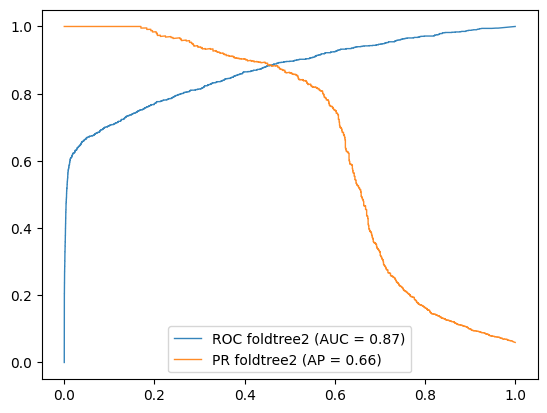

A0A162JUP8


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

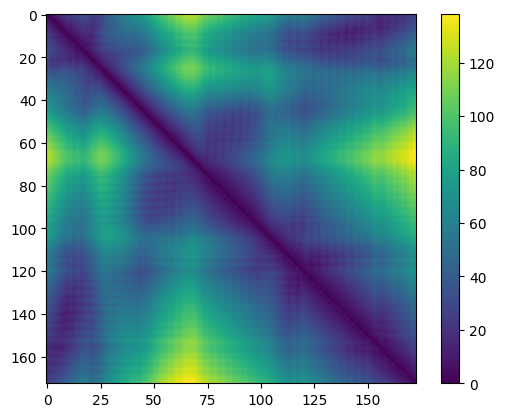

150
torch.Size([150, 20])
HeteroData(
  res={
    x=[150, 20],
    batch=[150],
  },
  positions={ x=[150, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 149] },
  (res, backbone_rev, res)={ edge_index=[2, 149] },
  (godnode4decoder, informs, res)={ edge_index=[2, 150] },
  (res, informs, godnode4decoder)={ edge_index=[2, 150] },
  (res, informs, godnode)={ edge_index=[2, 150] }
)
torch.Size([22500])
tensor([[-24.2473, -17.6495, -13.7062,  ..., -17.9639, -22.1181, -16.7596],
        [-24.0049, -17.4554, -13.6506,  ..., -17.6578, -21.9526, -16.4637],
        [-14.7063, -14.9447, -21.9565,  ..., -14.5680, -21.6417, -17.0733],
        ...,
        [-17.7965, -12.3691, -30.5555,  ..., -15.8640, -22.8009, -22.0112],
        [-16.7750, -17.8849, -23.2667,  ..., -17.0730, -23.2719, -19.3842],
        [-18.0447, -12.1893, -30.9725,  ..., -16.6379, -22.8909, -22.6788]],
       device='cuda:0', grad_fn=<CatBackward0>)
tensor([[9.9960e-01, 

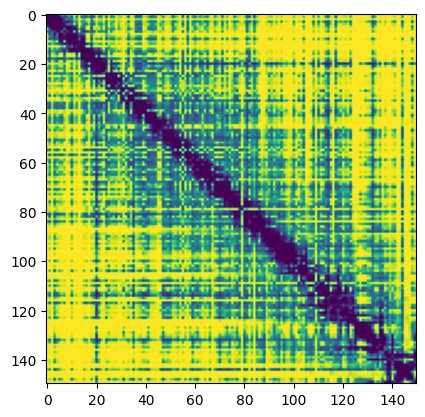

torch.Size([150, 150])
(173, 173)


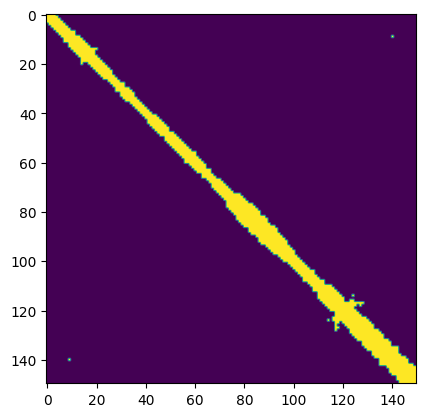

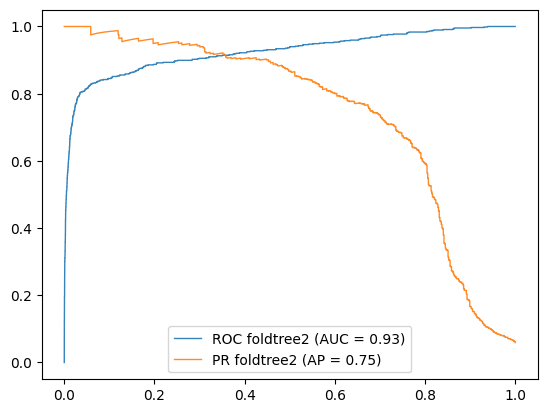

A0A1W9TUR9


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

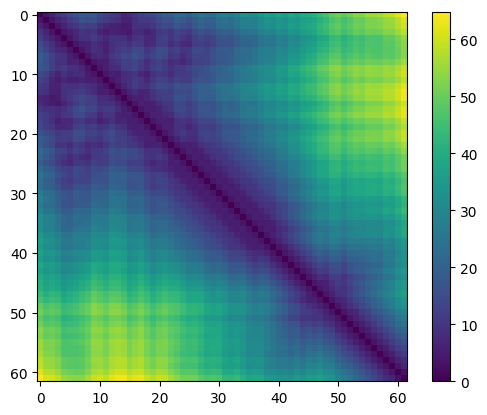

59
torch.Size([59, 20])
HeteroData(
  res={
    x=[59, 20],
    batch=[59],
  },
  positions={ x=[59, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 58] },
  (res, backbone_rev, res)={ edge_index=[2, 58] },
  (godnode4decoder, informs, res)={ edge_index=[2, 59] },
  (res, informs, godnode4decoder)={ edge_index=[2, 59] },
  (res, informs, godnode)={ edge_index=[2, 59] }
)
torch.Size([3481])
tensor([[-27.4983, -21.0012, -15.1684,  ..., -20.6912, -25.1503, -19.0057],
        [-27.1546, -20.6375, -14.9636,  ..., -20.2880, -24.7792, -18.6912],
        [-12.4466, -16.5900, -29.7999,  ..., -23.9854, -30.2708, -11.5923],
        ...,
        [-19.2766, -13.7735, -30.6078,  ..., -15.3819, -22.6154, -20.9078],
        [-32.4200, -16.8119, -37.3569,  ..., -28.2523, -17.8658, -34.1130],
        [-27.3274, -29.6961, -21.0471,  ..., -27.3390, -29.2692, -23.7454]],
       device='cuda:0', grad_fn=<CatBackward0>)
tensor([[9.9963e-01, 9.9791e-01,

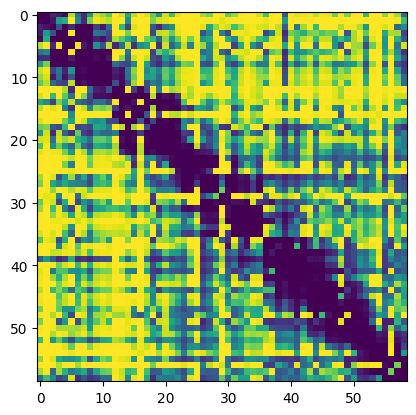

torch.Size([59, 59])
(62, 62)


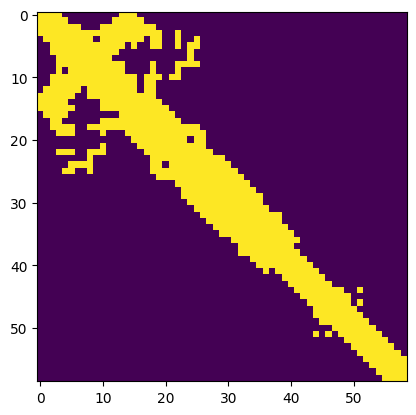

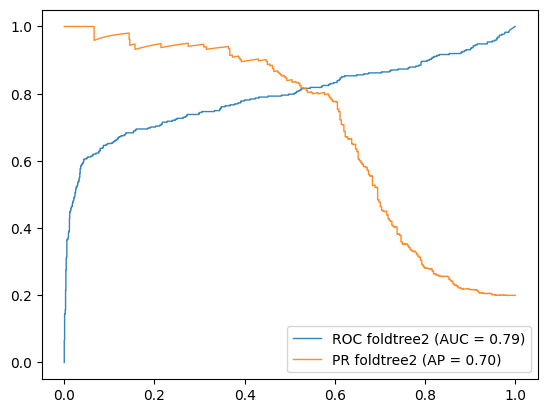

A0A350J482


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

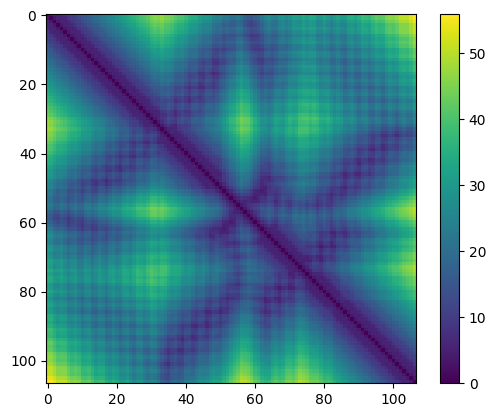

93
torch.Size([93, 20])
HeteroData(
  res={
    x=[93, 20],
    batch=[93],
  },
  positions={ x=[93, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 92] },
  (res, backbone_rev, res)={ edge_index=[2, 92] },
  (godnode4decoder, informs, res)={ edge_index=[2, 93] },
  (res, informs, godnode4decoder)={ edge_index=[2, 93] },
  (res, informs, godnode)={ edge_index=[2, 93] }
)
torch.Size([8649])
tensor([[-2.3396e+01, -1.6874e+01, -1.3818e+01,  ..., -1.7468e+01,
         -2.1439e+01, -1.6471e+01],
        [-2.4134e+01, -1.7734e+01, -1.4160e+01,  ..., -1.7812e+01,
         -2.2091e+01, -1.6708e+01],
        [-1.8836e+01, -1.6117e+01, -2.0554e+01,  ..., -2.2359e+01,
         -2.5158e+01, -1.8539e+01],
        ...,
        [-2.6790e+01, -1.2408e+01, -3.0896e+01,  ..., -2.3671e+01,
         -1.5813e+01, -2.8589e+01],
        [-1.8180e+01, -1.9073e-06, -3.8498e+01,  ..., -2.2326e+01,
         -2.7670e+01, -2.1046e+01],
        [-1.8666e+01, 

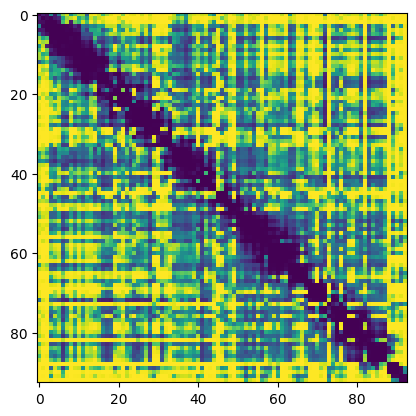

torch.Size([93, 93])
(107, 107)


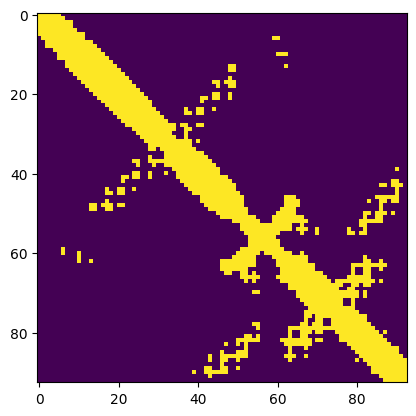

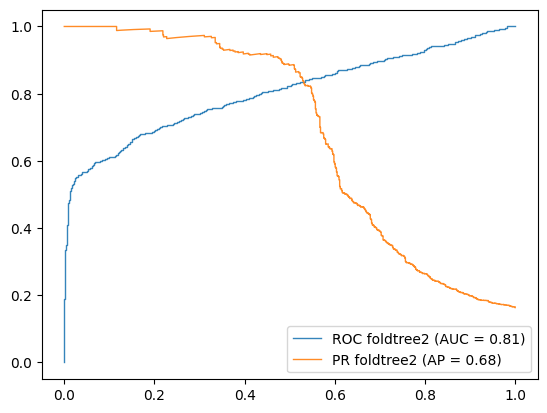

A0CST5


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

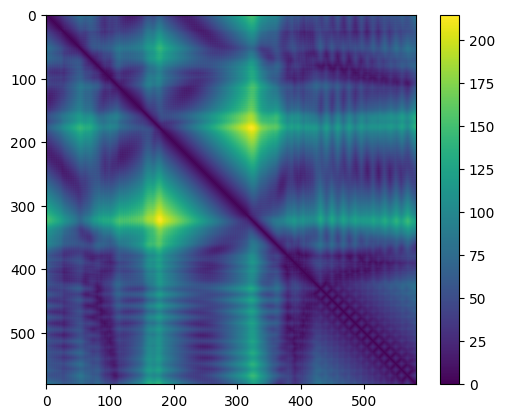

525
torch.Size([525, 20])
HeteroData(
  res={
    x=[525, 20],
    batch=[525],
  },
  positions={ x=[525, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 524] },
  (res, backbone_rev, res)={ edge_index=[2, 524] },
  (godnode4decoder, informs, res)={ edge_index=[2, 525] },
  (res, informs, godnode4decoder)={ edge_index=[2, 525] },
  (res, informs, godnode)={ edge_index=[2, 525] }
)
torch.Size([275625])
tensor([[-2.6768e+01, -2.0383e+01, -1.5302e+01,  ..., -1.9418e+01,
         -2.4326e+01, -1.8231e+01],
        [-2.6243e+01, -1.9810e+01, -1.5052e+01,  ..., -1.8930e+01,
         -2.3803e+01, -1.7889e+01],
        [-2.7013e+01, -2.0633e+01, -2.0781e+01,  ..., -2.0808e+01,
         -1.2927e+01, -2.2658e+01],
        ...,
        [-2.6469e+01, -2.9509e+01, -2.0403e+01,  ..., -2.6890e+01,
         -2.8662e+01, -2.3823e+01],
        [-2.8249e+01, -2.1700e+01, -2.2609e+01,  ..., -2.1706e+01,
         -1.2535e+01, -2.2873e+01],
        [-

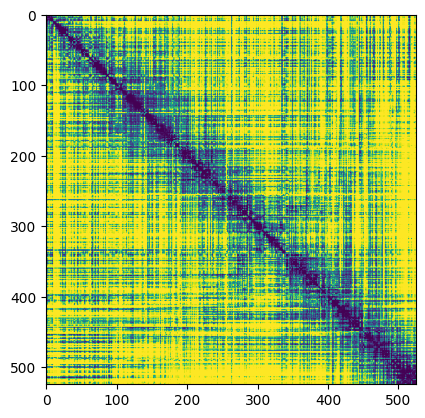

torch.Size([525, 525])
(581, 581)


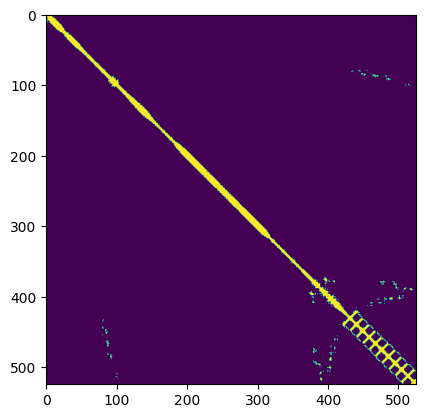

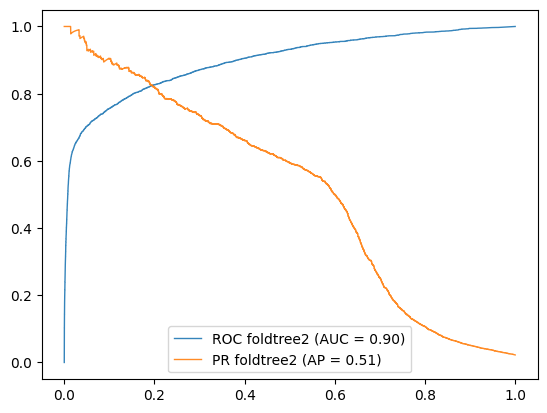

A0A3N5EDV9


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

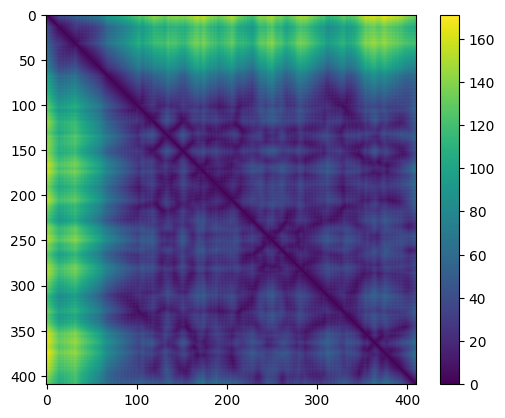

363
torch.Size([363, 20])
HeteroData(
  res={
    x=[363, 20],
    batch=[363],
  },
  positions={ x=[363, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 362] },
  (res, backbone_rev, res)={ edge_index=[2, 362] },
  (godnode4decoder, informs, res)={ edge_index=[2, 363] },
  (res, informs, godnode4decoder)={ edge_index=[2, 363] },
  (res, informs, godnode)={ edge_index=[2, 363] }
)
torch.Size([131769])
tensor([[-24.2048, -17.4796, -13.7856,  ..., -18.4022, -22.1530, -17.4377],
        [-23.6843, -16.8036, -13.1908,  ..., -18.0137, -21.4565, -17.4019],
        [-17.0969,  -8.7255, -18.3133,  ..., -11.5903, -10.8402, -16.0308],
        ...,
        [-16.1019, -17.1817, -10.0795,  ..., -17.5313, -19.2504, -16.9638],
        [-16.6877, -12.4848, -17.4823,  ..., -18.7413, -21.4213, -16.1250],
        [-20.9809, -19.5706, -15.2287,  ..., -24.2228, -17.0919, -19.7404]],
       device='cuda:0', grad_fn=<CatBackward0>)
tensor([[9.9962e-01,

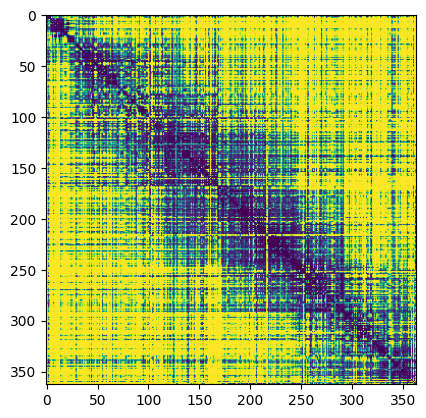

torch.Size([363, 363])
(410, 410)


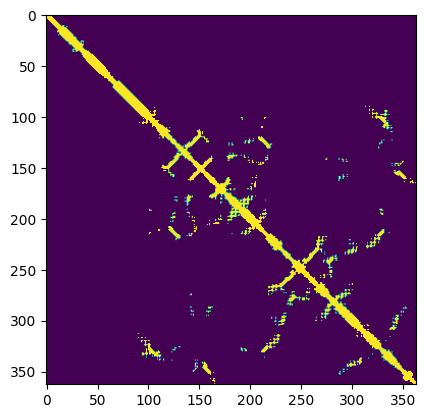

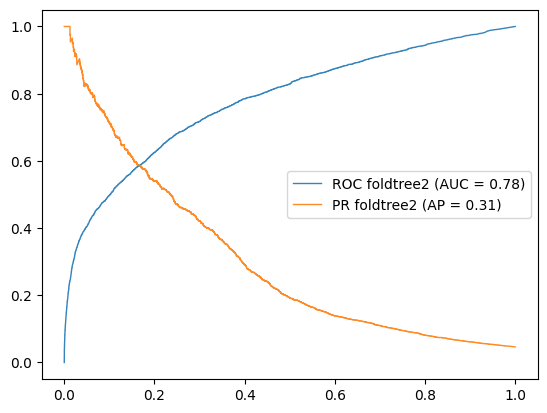

A0A7X4JF48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

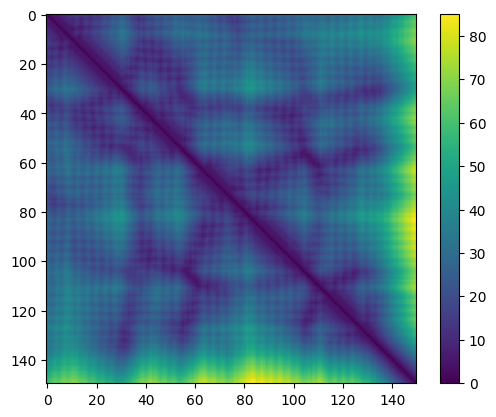

147
torch.Size([147, 20])
HeteroData(
  res={
    x=[147, 20],
    batch=[147],
  },
  positions={ x=[147, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 146] },
  (res, backbone_rev, res)={ edge_index=[2, 146] },
  (godnode4decoder, informs, res)={ edge_index=[2, 147] },
  (res, informs, godnode4decoder)={ edge_index=[2, 147] },
  (res, informs, godnode)={ edge_index=[2, 147] }
)
torch.Size([21609])
tensor([[-2.1539e+01, -1.5146e+01, -1.0792e+01,  ..., -1.8282e+01,
         -2.0079e+01, -1.7108e+01],
        [-2.1160e+01, -1.4791e+01, -1.0953e+01,  ..., -1.7755e+01,
         -1.9806e+01, -1.6527e+01],
        [-1.4065e+01, -1.4109e+01, -2.3755e+01,  ..., -1.1017e+01,
         -2.6367e+01, -2.0861e-05],
        ...,
        [-2.4171e+01, -1.5572e+01, -3.2073e+01,  ..., -2.9642e+01,
         -2.9768e+01, -3.0444e+01],
        [-2.3842e-06, -1.3946e+01, -2.5021e+01,  ..., -1.4121e+01,
         -2.2645e+01, -1.4998e+01],
        [-2

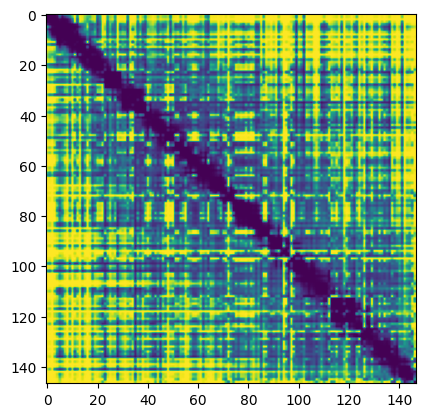

torch.Size([147, 147])
(150, 150)


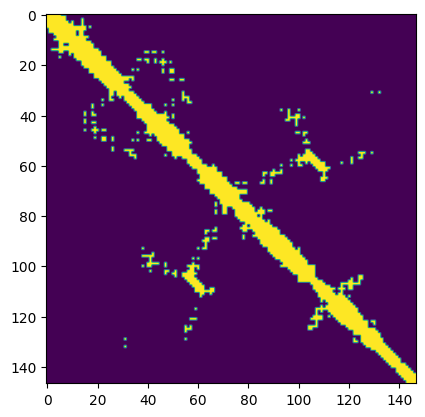

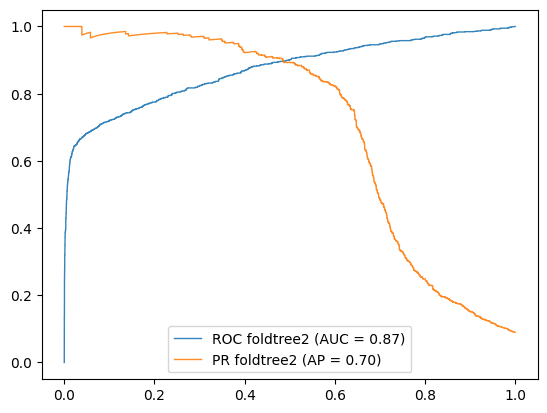

A0A838PRK3


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

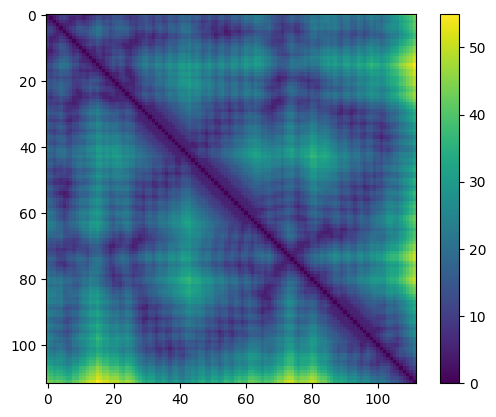

109
torch.Size([109, 20])
HeteroData(
  res={
    x=[109, 20],
    batch=[109],
  },
  positions={ x=[109, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 108] },
  (res, backbone_rev, res)={ edge_index=[2, 108] },
  (godnode4decoder, informs, res)={ edge_index=[2, 109] },
  (res, informs, godnode4decoder)={ edge_index=[2, 109] },
  (res, informs, godnode)={ edge_index=[2, 109] }
)
torch.Size([11881])
tensor([[-1.7153e+01, -1.6541e+01, -2.5622e+01,  ..., -1.8296e+01,
         -2.3740e+01, -2.0597e+01],
        [-1.7974e+01, -1.7521e+01, -2.7065e+01,  ..., -1.8805e+01,
         -2.5808e+01, -2.1472e+01],
        [-9.3228e+00, -1.0450e+01, -1.8255e+01,  ..., -7.0936e+00,
         -1.9351e+01, -1.3485e-03],
        ...,
        [-1.8095e+01, -2.3842e-07, -3.9715e+01,  ..., -2.4182e+01,
         -2.9861e+01, -2.1525e+01],
        [-2.0304e+01, -1.8884e+01, -1.5171e+01,  ..., -2.3662e+01,
         -1.6515e+01, -1.9272e+01],
        [-2

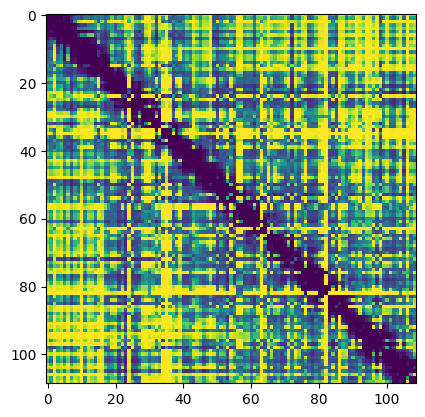

torch.Size([109, 109])
(112, 112)


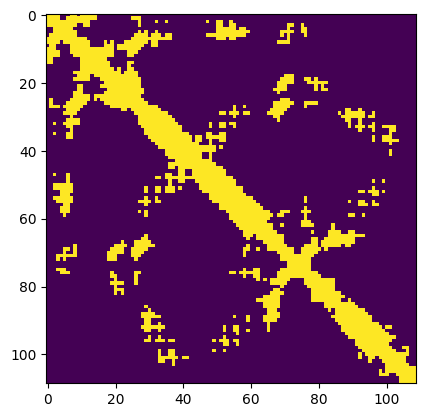

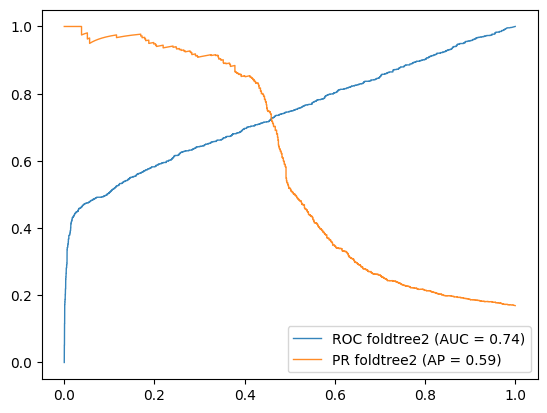

A0A0A6Q3E4


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

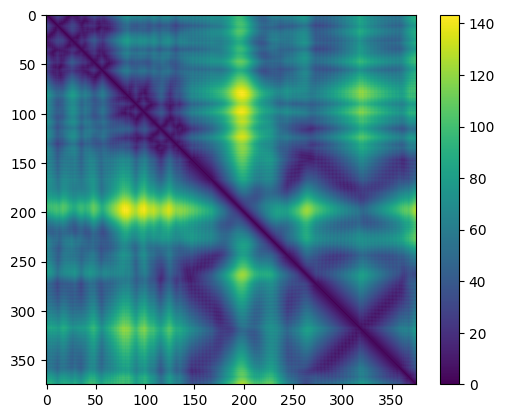

325
torch.Size([325, 20])
HeteroData(
  res={
    x=[325, 20],
    batch=[325],
  },
  positions={ x=[325, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 324] },
  (res, backbone_rev, res)={ edge_index=[2, 324] },
  (godnode4decoder, informs, res)={ edge_index=[2, 325] },
  (res, informs, godnode4decoder)={ edge_index=[2, 325] },
  (res, informs, godnode)={ edge_index=[2, 325] }
)
torch.Size([105625])
tensor([[-26.8873, -20.1860, -14.1139,  ..., -21.9284, -24.5916, -20.0045],
        [-26.6177, -19.8873, -13.9750,  ..., -21.4842, -24.2237, -19.6729],
        [-14.2539, -13.7117,  -5.4587,  ..., -14.2241, -14.8150, -15.7523],
        ...,
        [-28.8246, -15.4784, -33.0260,  ..., -23.8952, -14.5922, -30.2726],
        [-16.2224, -16.0108, -29.3149,  ..., -25.2779, -28.3213, -13.8250],
        [-30.6059, -25.5113, -17.6368,  ..., -21.4947, -28.5157, -18.1878]],
       device='cuda:0', grad_fn=<CatBackward0>)
tensor([[9.9951e-01,

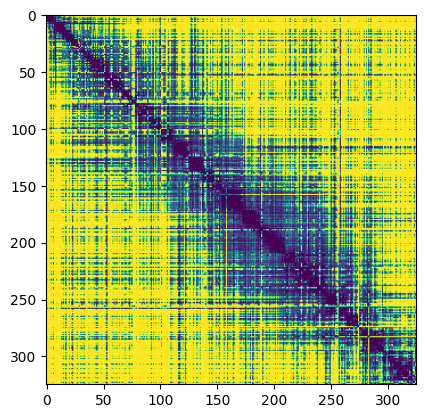

torch.Size([325, 325])
(375, 375)


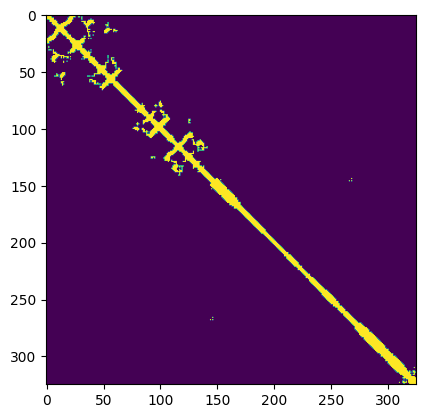

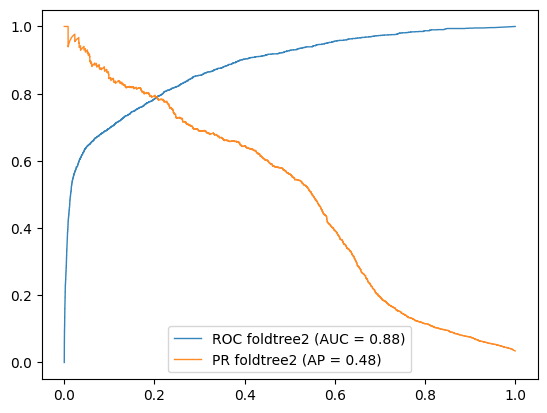

W4U6Q6


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

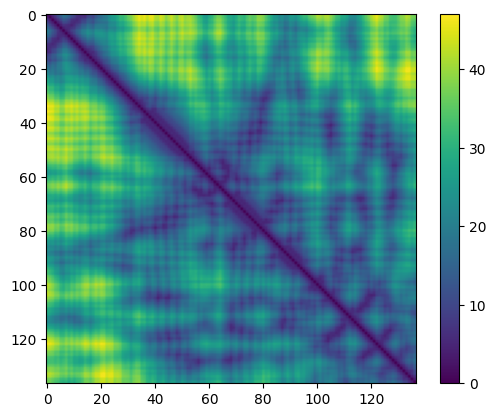

129
torch.Size([129, 20])
HeteroData(
  res={
    x=[129, 20],
    batch=[129],
  },
  positions={ x=[129, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 128] },
  (res, backbone_rev, res)={ edge_index=[2, 128] },
  (godnode4decoder, informs, res)={ edge_index=[2, 129] },
  (res, informs, godnode4decoder)={ edge_index=[2, 129] },
  (res, informs, godnode)={ edge_index=[2, 129] }
)
torch.Size([16641])
tensor([[-2.6862e+01, -2.0228e+01, -1.4739e+01,  ..., -2.0742e+01,
         -2.4593e+01, -1.9086e+01],
        [-2.6595e+01, -1.9879e+01, -1.4697e+01,  ..., -2.0508e+01,
         -2.4247e+01, -1.9003e+01],
        [-2.8848e-05, -1.3187e+01, -2.1992e+01,  ..., -1.0789e+01,
         -1.9398e+01, -1.2328e+01],
        ...,
        [-1.6065e+01, -2.0481e+01, -3.3837e+01,  ..., -3.0881e+01,
         -3.4454e+01, -1.6711e+01],
        [-2.1995e+01, -2.0836e+01, -1.5674e+01,  ..., -2.5219e+01,
         -1.7690e+01, -2.0659e+01],
        [-1

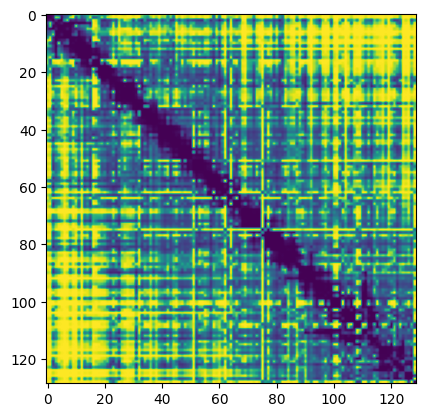

torch.Size([129, 129])
(137, 137)


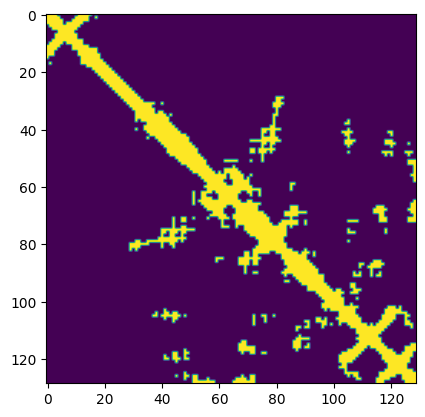

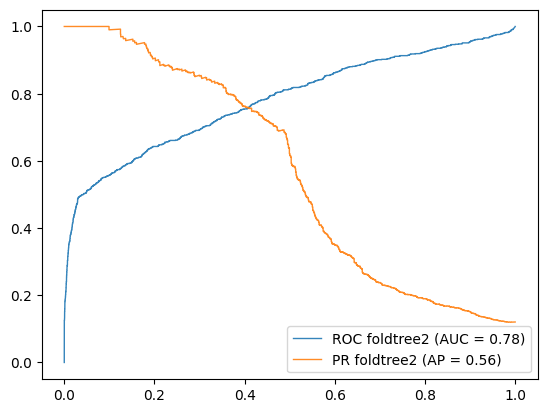

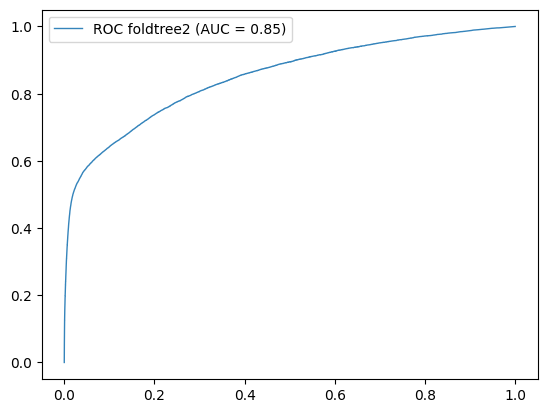

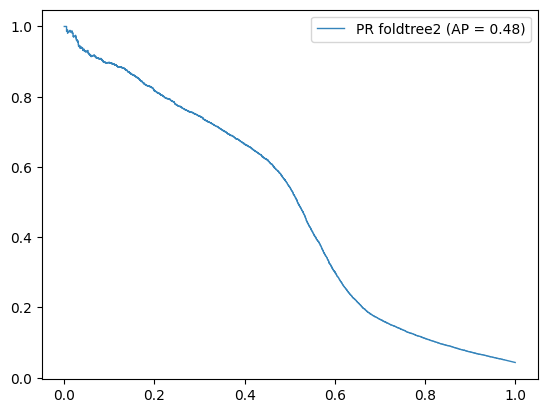

In [20]:
from Bio import PDB
from Bio.PDB import PDBParser
from sklearn.metrics import roc_curve, auc , precision_recall_curve, average_precision_score
from scipy import sparse
import torch_geometric
import losses

def get_alpha_carbon_distance_matrix(pdb_file):
	"""
	Extracts the alpha carbon (Cα) atoms from a PDB structure
	and computes the distance matrix in numpy format.

	Parameters:
	pdb_file (str): Path to the PDB file.

	Returns:
	numpy.ndarray: A matrix of distances between all Cα atoms.
	"""
	# Initialize the PDB parser
	parser = PDBParser(QUIET=True)
	
	# Parse the structure
	structure = parser.get_structure('structure', pdb_file)
	
	# Extract alpha carbon (Cα) atoms
	ca_atoms = []
	for model in structure:
		for chain in model:
			for residue in chain :
				if 'CA' in residue and PDB.is_aa(residue) :
					ca_atoms.append(residue['CA'])
	
	# Get the number of Cα atoms
	num_atoms = len(ca_atoms)
	
	# Initialize the distance matrix
	dist_matrix = np.zeros((num_atoms, num_atoms))
	
	# Compute the distances between all pairs of Cα atoms
	for i, atom_i in enumerate(ca_atoms):
		for j, atom_j in enumerate(ca_atoms):
			if i < j:
				dist_matrix[i, j] = atom_i - atom_j
	dist_matrix += dist_matrix.T
	return dist_matrix

#get aa and contacts
def get_backbone(naa):
	backbone_mat = np.zeros((naa, naa))
	backbone_rev_mat = np.zeros((naa, naa))
	np.fill_diagonal(backbone_mat[1:], 1)
	np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
	return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
	sparsemat = sparse.find(sparsemat)
	return np.vstack([sparsemat[0],sparsemat[1]])

def decoder_reconstruction2aa( ords , device, verbose = False):
	decoder.eval()
	z = encoder.vector_quantizer.embeddings( ords  ).to('cpu')
	print( z.shape)
	edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	godnode_index = np.vstack([np.zeros(z.shape[0]), [ i for i in range(z.shape[0]) ] ])
	godnode_rev = np.vstack([ [ i for i in range(z.shape[0]) ] , np.zeros(z.shape[0]) ])
	#generate a backbone for the decoder
	data = HeteroData()
	data['res'].x = z
	backbone, backbone_rev = get_backbone( z.shape[0] )
	backbone = sparse.csr_matrix(backbone)
	backbone_rev = sparse.csr_matrix(backbone_rev)
	backbone = sparse2pairs(backbone)
	backbone_rev = sparse2pairs(backbone_rev)
	positional_encoding = converter.get_positional_encoding( z.shape[0] , 256 )
	data['res'].batch = torch.tensor([0 for i in range(z.shape[0])], dtype=torch.long)
	data['positions'].x = torch.tensor( positional_encoding, dtype=torch.float32)
	data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
	data[ 'res' , 'backbone_rev' , 'res'].edge_index = torch.tensor(backbone_rev, dtype=torch.long)
	#add the godnode
	data['godnode'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder', 'informs', 'res'].edge_index = torch.tensor(godnode_index, dtype=torch.long)
	data['res', 'informs', 'godnode4decoder'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	data['res', 'informs', 'godnode'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	edge_index = edge_index.to( device )
	print( data )
	data = data.to( device )
	allpairs = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	out = decoder( data , allpairs ) 

	recon_x = out['aa'] if 'aa' in out else None
	edge_probs = out['edge_probs'] if 'edge_probs' in out else None

	print( edge_probs.shape)
	amino_map = decoder.decoders['sequence_transformer'].amino_acid_indices
	revmap_aa = { v:k for k,v in amino_map.items() }
	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	if verbose == True:
		print( recon_x )
		print( edge_probs )
	aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
	return aastr ,edge_probs

postives = []
predictions = []
for ex in range( encoded_df.shape[0] ):
	os.makedirs('tmp', exist_ok=True)
	example = encoded_df.iloc[ex]
	protid = encoded_df.index[ex]
	ords = example['ord']
	print( str(protid))
	AFDB_tools.grab_struct(str(protid) , structfolder='tmp/')
	#show struct
	view_custom_pdb('tmp/' + protid + '.pdb', chain='A')
	#get alpha carbon distmat with biopython
	s = get_alpha_carbon_distance_matrix( 'tmp/' + protid + '.pdb')
	#threshold the distance matrix
	plt.imshow(s)
	plt.colorbar()
	plt.show()
	#these are the embedding indices. shift by 1 to get the hex indices
	ords = torch.tensor([ c-1 if c not in rev_replace_dict_ord else rev_replace_dict_ord[c]-1 for c in ords] , dtype=torch.long)
	print( len(ords))
	ords = ords.to(device)	
	aa, edgeprobs = decoder_reconstruction2aa( ords , device = device, verbose = True)
	print(aa)
	#change range of image to 0-1
	probs = 1-edgeprobs.detach().cpu()
	probs = (probs + probs.T)/2
	plt.imshow(probs) 
	plt.show()
	print( probs.shape)
	print( s.shape)
	#output ROC curve for contact prediction

	pos = np.zeros( s.shape )
	pos[ s < 10] = 1
	pos = pos[ 0:probs.shape[0], 0:probs.shape[1]]
	plt.imshow(pos)
	plt.show()

	postives.append(pos.flatten())
	predictions.append(probs.flatten())

	#flatten the matrices
	pos = pos.flatten()
	probs = probs.flatten()
	fpr, tpr, thresholds = roc_curve(pos, 1-probs)
	roc_auc = auc(fpr, tpr)
	plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC foldtree2 (AUC = %0.2f)' % (roc_auc))

	#output precision recall curve
	precision, recall, thresholds = precision_recall_curve(pos, 1-probs)
	average_precision = average_precision_score(pos, 1-probs)
	plt.plot(recall, precision, lw=1, alpha=0.9, label='PR foldtree2 (AP = %0.2f)' % (average_precision))
	plt.legend()
	plt.show()

#output ROC curve for contact prediction
postives = np.concatenate(postives)
predictions = np.concatenate(predictions)
fpr, tpr, thresholds = roc_curve(postives, 1-predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC foldtree2 (AUC = %0.2f)' % (roc_auc))
plt.legend()
plt.show()

#output precision recall curve
precision, recall, thresholds = precision_recall_curve(postives, 1-predictions)
average_precision = average_precision_score(postives, 1-predictions)
plt.plot(recall, precision, lw=1, alpha=0.9, label='PR foldtree2 (AP = %0.2f)' % (average_precision))
plt.legend()
plt.show()


In [21]:
# Function to compute Root Mean Square Deviation (RMSD)
def compute_rmsd(coords1, coords2):
    """
    Compute the Root Mean Square Deviation (RMSD) between two sets of coordinates.
    
    Parameters:
    - coords1: Nx3 NumPy array of true coordinates
    - coords2: Nx3 NumPy array of predicted coordinates
    
    Returns:
    - RMSD value
    """
    assert coords1.shape == coords2.shape, "Coordinate arrays must have the same shape"
    
    diff = coords1 - coords2
    rmsd = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
    return rmsd

# Function to compute Local Distance Difference Test (lDDT)
def compute_lddt(true_coords, pred_coords, cutoff=15.0):
    """
    Compute the Local Distance Difference Test (lDDT) score.
    
    Parameters:
    - true_coords: Nx3 NumPy array of true coordinates
    - pred_coords: Nx3 NumPy array of predicted coordinates
    - cutoff: Distance threshold for considering a pair of residues
    
    Returns:
    - lDDT score (0 to 1)
    """
    assert true_coords.shape == pred_coords.shape, "Coordinate arrays must have the same shape"

    num_residues = true_coords.shape[0]
    num_pairs = 0
    num_matching_pairs = 0

    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            true_dist = np.linalg.norm(true_coords[i] - true_coords[j])
            pred_dist = np.linalg.norm(pred_coords[i] - pred_coords[j])

            if true_dist < cutoff:
                num_pairs += 1
                if abs(true_dist - pred_dist) < 0.5 * true_dist:
                    num_matching_pairs += 1

    lddt_score = num_matching_pairs / num_pairs if num_pairs > 0 else 0
    return lddt_score

# Compute RMSD and lDDT
rmsd_value = compute_rmsd(true_coords_from_rt, pred_coords_from_rt)
lddt_value = compute_lddt(true_coords_from_rt, pred_coords_from_rt)

rmsd_value, lddt_value


NameError: name 'true_coords_from_rt' is not defined

In [19]:

#plot the true and predicted structures
def transform_rt_to_coordinates(rotations, translations):
    """
    Given a list of rotation matrices (R) and translation vectors (t),
    generate the global 3D coordinates of the protein backbone.
    
    Parameters:
    - rotations: List of 3x3 rotation matrices
    - translations: List of 3x1 translation vectors
    
    Returns:
    - coords: Nx3 NumPy array representing the backbone in 3D space
    """
    num_residues = len(rotations)
    assert num_residues == len(translations), "Rotation and translation lists must be the same length"
    
    # Initialize the first coordinate at the origin
    coords = [np.array([0, 0, 0, 1])]  # Homogeneous coordinates

    # Apply transformations iteratively
    current_transform = np.eye(4)  # Identity matrix as starting point

    for R, t in zip(rotations, translations):
        # Construct the transformation matrix (4x4)
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        
        # Update the cumulative transformation
        current_transform = current_transform @ T
        
        # Transform the point and store the new coordinates
        new_point = current_transform @ np.array([0, 0, 0, 1])  # Homogeneous coordinates
        coords.append(new_point)

    return np.array(coords)[:, :3]  # Convert back to 3D coordinates (drop the homogeneous coordinate)


def plot_protein_structures_with_thicker_lines(true_coords, pred_coords):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot true structure with thicker lines and transparency
    ax.plot(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2], 
            'bo-', alpha=0.5, label='True Structure', linewidth=3, markersize=6)

    # Plot predicted structure with thicker lines and transparency
    ax.plot(pred_coords[:, 0], pred_coords[:, 1], pred_coords[:, 2], 
            'ro-', alpha=0.5, label='Predicted Structure', linewidth=3, markersize=6)

    # Adjusted arrow size
    arrow_size = 0.15  # Keep small arrows

    # Add arrowheads to indicate backbone direction
    for i in range(len(true_coords) - 1):
        ax.quiver(true_coords[i, 0], true_coords[i, 1], true_coords[i, 2],
                  true_coords[i+1, 0] - true_coords[i, 0], 
                  true_coords[i+1, 1] - true_coords[i, 1], 
                  true_coords[i+1, 2] - true_coords[i, 2],
                  color='blue', alpha=0.5, arrow_length_ratio=arrow_size)

    for i in range(len(pred_coords) - 1):
        ax.quiver(pred_coords[i, 0], pred_coords[i, 1], pred_coords[i, 2],
                  pred_coords[i+1, 0] - pred_coords[i, 0], 
                  pred_coords[i+1, 1] - pred_coords[i, 1], 
                  pred_coords[i+1, 2] - pred_coords[i, 2],
                  color='red', alpha=0.5, arrow_length_ratio=arrow_size)

    # Labels and legend
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('True vs Predicted Protein Backbone Structure with Thicker Lines')
    ax.legend()

    plt.show()

# Plot with thicker lines
plot_protein_structures_with_thicker_lines(true_coords, noisy_pred_coords)


NameError: name 'true_coords' is not defined